In [144]:
# 加载必要的库

import sys
import pandas as pd
import numpy as np
import sklearn
import random
import time


In [145]:
sys.version

'3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]'

In [146]:
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

### 第一步：加载原数据集

In [147]:
data_raw = pd.read_csv('train.csv')

data_val = pd.read_csv('test.csv')


In [148]:
# 显示部分数据

data_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [149]:
data_val.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [150]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [151]:
data_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [152]:
# 列名称全部转换为小写格式

data_raw.columns = data_raw.columns.str.lower()  
data_val.columns = data_val.columns.str.lower()

In [153]:
data_raw.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

<Axes: ylabel='count'>

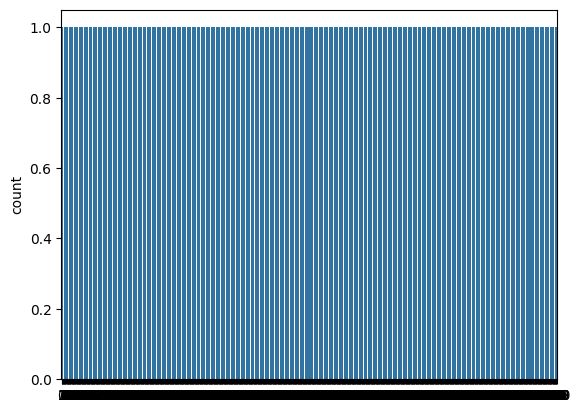

In [154]:
# 绘制图形

sns.countplot(data_raw['survived'])

In [155]:
# 合并两个数据集，进行统一的清洗

data_all = [data_raw,data_val]


### 数据清洗

In [156]:
data_raw.isnull().sum() # 统计训练集中哪些特征（列）里有NULL

passengerid      0
survived         0
pclass           0
name             0
sex              0
age            177
sibsp            0
parch            0
ticket           0
fare             0
cabin          687
embarked         2
dtype: int64

In [157]:
data_val.isnull().sum()  # 统计验证集中哪些特征（列）里有NULL

passengerid      0
pclass           0
name             0
sex              0
age             86
sibsp            0
parch            0
ticket           0
fare             1
cabin          327
embarked         0
dtype: int64

In [158]:
# 对原数据进行描述

data_raw.describe(include='all')

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Dooley, Mr. Patrick",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [159]:
# 对原始数据集（训练集 + 验证集）进行清理

for dataset in data_all:
    # 补足空缺值   inplace 方法已经弃用了，直接赋值即可
    # dataset['age'].fillna(dataset['age'].median(), inplace=True)
    # dataset['fare'].fillna(dataset['fare'].median(), inplace=True)
    # dataset['embarked'].fillna(dataset['embarked'].mode()[0], inplace=True)
    dataset['age'] = dataset['age'].fillna(dataset['age'].median())
    dataset['fare'] = dataset['fare'].fillna(dataset['fare'].median())
    dataset['embarked'] = dataset['embarked'].fillna(dataset['embarked'].mode()[0])


In [160]:
data_raw.isnull().sum()
data_val.isnull().sum()

passengerid      0
pclass           0
name             0
sex              0
age              0
sibsp            0
parch            0
ticket           0
fare             0
cabin          327
embarked         0
dtype: int64

In [161]:
# 删除一些字段

drop_columns = ['cabin', 'passengerid', 'ticket']

data_raw = data_raw.drop(drop_columns,axis=1,errors='ignore')

data_val = data_val.drop(drop_columns,axis=1,errors='ignore')

data_all = [data_raw] + [data_val]


In [162]:
data_raw.columns

Index(['survived', 'pclass', 'name', 'sex', 'age', 'sibsp', 'parch', 'fare',
       'embarked'],
      dtype='object')

In [163]:
data_raw.isnull().sum()

survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

In [164]:
data_val.isnull().sum()

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
dtype: int64

### 第三步：进行特征的构建


In [165]:
for dataset in data_all:
    # 构建新的字段：
    # (1) family_size 家庭规模：sibsp + parch

    dataset['family_size'] = dataset['sibsp'] + dataset['parch'] + 1

    # (2) single 单身：1：单身；0：非单身

    dataset['single'] = 1
    dataset.loc[dataset['family_size'] > 1, 'single'  ] = 0 

    # (3) title 身份 

    dataset['title'] = dataset['name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]   # expand 默认series返回列，true返回dataframe [1]表示第二个元素
    
    # (4) fare_bin 票价 (不分组太多类了)

    dataset['fare_bin'] = pd.qcut(dataset['fare'], 4) # 根据票价分成4组，每组的元素的个数一致

    # (5) age_bin 年龄

    dataset['age_bin'] = pd.cut(dataset['age'].astype(int), 5) # 根据年龄分组，分成5组(每组的元素不一致)
    
    




In [166]:
dataset.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked,family_size,single,title,fare_bin,age_bin
0,3,"Kelly, Mr. James",male,34.5,0,0,7.8292,Q,1,1,Mr,"(-0.001, 7.896]","(30.4, 45.6]"
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,7.0000,S,2,0,Mrs,"(-0.001, 7.896]","(45.6, 60.8]"
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,9.6875,Q,1,1,Mr,"(7.896, 14.454]","(60.8, 76.0]"
3,3,"Wirz, Mr. Albert",male,27.0,0,0,8.6625,S,1,1,Mr,"(7.896, 14.454]","(15.2, 30.4]"
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,12.2875,S,3,0,Mrs,"(7.896, 14.454]","(15.2, 30.4]"


In [167]:
# 根据title统计人数

data_raw['title'].value_counts()

title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64

In [168]:
title_names = (data_raw['title'].value_counts() < 10)
title_names

title
Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Major            True
Ms               True
Mme              True
Don              True
Lady             True
Sir              True
Capt             True
the Countess     True
Jonkheer         True
Name: count, dtype: bool

In [ ]:
# title 将哪些称谓人数小于10的数据，全部归为一类：other
# 统计每个 title 的出现次数
title_counts = data_raw['title'].value_counts()

# 创建掩码：出现次数 < 10 的为 True
mask = title_counts < 10
print(mask)
# 把出现次数少的 title 映射为 'other'，其他的保持不变
data_raw['title'] = data_raw['title'].map(
    lambda x: 'other' if mask[x] else x
)

title
Mr              False
Miss            False
Mrs             False
Master          False
Dr               True
Rev              True
Col              True
Mlle             True
Major            True
Ms               True
Mme              True
Don              True
Lady             True
Sir              True
Capt             True
the Countess     True
Jonkheer         True
Name: count, dtype: bool


In [174]:
data_raw['title']

0         Mr
1        Mrs
2       Miss
3        Mrs
4         Mr
       ...  
886    other
887     Miss
888     Miss
889       Mr
890       Mr
Name: title, Length: 891, dtype: object

In [176]:
data_raw['title'].value_counts()

title
Mr        517
Miss      182
Mrs       125
Master     40
other      27
Name: count, dtype: int64

In [177]:
data_raw['survived'].groupby(data_raw['title']).mean()

title
Master    0.575000
Miss      0.697802
Mr        0.156673
Mrs       0.792000
other     0.444444
Name: survived, dtype: float64